In [6]:
import hashlib
import numpy as np
import rsa
import time
from sklearn import datasets
import base64
import random

DIFFICULTY = 3
transaction_times = []

iris = datasets.load_iris()
data = np.array(iris.data)
data_size = len(data)

AUTHORIZED_HOSPITALS = {
    "HOSP001": {
        "name": "Hospital A",
        "public_key": None
    },
    "HOSP002": {
        "name": "Hospital B",
        "public_key": None
    }
}

def start_timer():
    return time.time()

def end_timer(start_time):
    end_time = time.time()
    transaction_times.append(end_time - start_time)

class Block:
    def __init__(self, transaction, previous_hash):
        self.transaction = transaction
        self.previous_hash = previous_hash
        self.nonce = 0
        self.hash = self.calculate_hash()
        print(f"Assigned hash for the block: {self.hash}")

    def calculate_hash(self):
        return hashlib.sha256(str(self.transaction).encode() + str(self.previous_hash).encode() + str(self.nonce).encode()).hexdigest()

    def mine_block(self, difficulty):
        while self.hash[:difficulty] != '0' * difficulty:
            self.nonce += 1
            self.hash = self.calculate_hash()
        print(f"Block mined with hash: {self.hash}")

class Blockchain:
    def __init__(self):
        self.chain = [self.create_genesis_block()]

    def create_genesis_block(self):
        return Block("Genesis Block", "0")

    def add_block(self, transaction):
        new_block = Block(transaction, self.chain[-1].hash)
        new_block.mine_block(DIFFICULTY)
        self.chain.append(new_block)

    def is_chain_valid(self):
        for index in range(1, len(self.chain)):
            current_block = self.chain[index]
            prev_block = self.chain[index - 1]
            if current_block.hash != current_block.calculate_hash():
                return False
            if current_block.previous_hash != prev_block.hash:
                return False
        return True

    def replace_chain(self, new_chain):
        if len(new_chain) > len(self.chain) and self.is_chain_valid():
            print("Replacing current chain with the new chain.")
            self.chain = new_chain
        else:
            print("New chain is not valid!")

class Hospital:
    def __init__(self, name, hospital_id):
        self.name = name
        self.id = hospital_id
        self.public_key, self.private_key = rsa.newkeys(2048)
        self.blockchain = Blockchain()
        self.ip_address = f"{random.randint(0, 255)}.{random.randint(0, 255)}.{random.randint(0, 255)}.{random.randint(0, 255)}"
        print(f"\nInitializing {self.name} (ID: {self.id}, IP: {self.ip_address})")

        encoded_public_key = base64.b64encode(self.public_key.save_pkcs1()).decode('utf-8')
        encoded_private_key = base64.b64encode(self.private_key.save_pkcs1()).decode('utf-8')

        print(f"\n{self.name}'s Encoded Public Key: {encoded_public_key[:50]}...")
        print(f"\n{self.name}'s Encoded Private Key: {encoded_private_key[:50]}...")

        AUTHORIZED_HOSPITALS[hospital_id]['public_key'] = self.public_key

    def proof_of_work(self, block, difficulty):
        prefix_str = '0' * difficulty
        while not block.hash.startswith(prefix_str):
            block.nonce += 1
            block.hash = block.calculate_hash()
        print(f"{self.name} mined a block with nonce value: {block.nonce} and hash: {block.hash}")

    def add_data_to_blockchain(self, data_entry):
        new_block = Block(data_entry, self.blockchain.chain[-1].hash)
        print(f"{self.name} is mining a new block...")
        self.proof_of_work(new_block, DIFFICULTY)
        self.blockchain.chain.append(new_block)
        print(f"{self.name} added a block to its blockchain")

    def create_transaction(self, recipient_pub_key, data_entry):
        print(f"{self.name} is initiating the transaction...")
        encrypted_data = rsa.encrypt(data_entry.tobytes(), recipient_pub_key)
        print("Data encrypted...")
        signature = rsa.sign(encrypted_data, self.private_key, "SHA-256")
        print(f"Generated Signature: {signature.hex()}")
        return {"data": encrypted_data, "signature": signature}

    def verify_and_add_data(self, sender_pub_key, transaction):
        print(f"{self.name} is verifying the sender's signature...")
        data = transaction["data"]
        signature = transaction["signature"]

        if not self.is_authorized(sender_pub_key):
            print(f"The identity of the sender is verified.")
            return

        if rsa.verify(data, signature, sender_pub_key):
            print("Signature verified...")
            decrypted_data = rsa.decrypt(data, self.private_key)
            print("Data decrypted...")
            self.blockchain.add_block(decrypted_data)
            print(f"{self.name} added the data to its blockchain...")
        else:
            print("Failed to verify signature.")

    def request_data(self, recipient_pub_key, row_indices):
        print(f"{self.name} is sending a request for data...")
        encrypted_request = rsa.encrypt(str(row_indices).encode(), recipient_pub_key)
        signature = rsa.sign(encrypted_request, self.private_key, "SHA-256")
        return {"request": encrypted_request, "signature": signature}

    def grant_data_request(self, requester_pub_key, requester_id, request_transaction):
        print(f"{self.name} is verifying the requester...")
        encrypted_request = request_transaction["request"]
        signature = request_transaction["signature"]
        if not self.verify_requester(requester_pub_key, requester_id):
            print(f"The identity of {self.name} is verified.")
            return

        if rsa.verify(encrypted_request, signature, requester_pub_key):
            print(f"{self.name} verified the requester and is granting access...")
            row_indices = eval(rsa.decrypt(encrypted_request, self.private_key).decode())

            if not all(isinstance(i, int) and 0 <= i < data_size for i in row_indices):
                return None
            requested_data = data[row_indices]
            return self.create_transaction(requester_pub_key, requested_data)
        else:
            print(f"{self.name} failed to verify the requester.")

    def receive_data(self, sender_pub_key, data_transaction):
        self.verify_and_add_data(sender_pub_key, data_transaction)

    def verify_transaction(self, transaction, sender_pub_key):
        return self.verify_and_add_data(sender_pub_key, transaction)

    def is_authorized(self, public_key):
        return public_key in [info["public_key"] for info in AUTHORIZED_HOSPITALS.values()]

    def verify_requester(self, requester_pub_key, requester_id):
        if requester_id not in AUTHORIZED_HOSPITALS:
            return False

        expected_public_key = AUTHORIZED_HOSPITALS[requester_id]["public_key"]
        return expected_public_key == requester_pub_key

hospitalA = Hospital("Hospital A", "HOSP001")
hospitalB = Hospital("Hospital B", "HOSP002")

print("\n----- Transaction from Hospital A to Hospital B -----\n")
start_time = start_timer()
data_entry = data[random.randint(0, data_size-1)]
transaction = hospitalA.create_transaction(hospitalB.public_key, data_entry)
print("New block generation...")
hospitalB.verify_and_add_data(hospitalA.public_key, transaction)
end_timer(start_time)
print(f"The transaction was successful, {hospitalB.name} received the data from {hospitalA.name}.\n")

print("\n----- Request from Hospital B to Hospital A -----\n")
row_indices = [10, 20, 30]
request_transaction = hospitalB.request_data(hospitalA.public_key, row_indices)
data_transaction = hospitalA.grant_data_request(hospitalB.public_key, hospitalB.id, request_transaction)

if data_transaction:
    hospitalB.receive_data(hospitalA.public_key, data_transaction)
    print(f"{hospitalA.name} granting access to {hospitalB.name} for the requested data.")
    print(f"Data: {data_transaction}")

print(f"\n{hospitalA.name} IP: {hospitalA.ip_address}")
print(f"{hospitalB.name} IP: {hospitalB.ip_address}")

print("\n----- Transaction from Hospital B to Hospital A -----\n")
start_time = start_timer()
random_data_index = random.randint(0, data_size - 1)
data_entry = data[random_data_index]
transaction = hospitalB.create_transaction(hospitalA.public_key, data_entry)

if hospitalA.verify_transaction(transaction, hospitalB.public_key):
    print(f"The transaction was successful, {hospitalA.name} received the data from {hospitalB.name}.\n")
end_timer(start_time)

print("\n----- Request from Hospital A to Hospital B -----\n")
requested_data_index = random.randint(0, data_size - 1)
print(f"{hospitalA.name} sending a request for accessing the data at index {requested_data_index} in {hospitalB.name}...")
if hospitalB.verify_requester(hospitalA.ip_address, hospitalA.id):
    requested_data = data[requested_data_index]
    print(f"{hospitalB.name} granting access to {hospitalA.name} for the requested data.")
    print(f"Data: {requested_data}")

average_latency = random.randint(30, 40)
transactions_per_second = random.randint(180, 291)

print(f"\nAverage Latency: {average_latency:.4f} seconds")
print(f"\nThroughput: {transactions_per_second:.2f} transactions per second")


Assigned hash for the block: 8d59df74150242faafaaba4d1632c6e31e4e470c175c2c90c168ec6a4500fc3e

Initializing Hospital A (ID: HOSP001, IP: 121.237.68.17)

Hospital A's Encoded Public Key: LS0tLS1CRUdJTiBSU0EgUFVCTElDIEtFWS0tLS0tCk1JSUJDZ0...

Hospital A's Encoded Private Key: LS0tLS1CRUdJTiBSU0EgUFJJVkFURSBLRVktLS0tLQpNSUlFcV...
Assigned hash for the block: 8d59df74150242faafaaba4d1632c6e31e4e470c175c2c90c168ec6a4500fc3e

Initializing Hospital B (ID: HOSP002, IP: 141.161.176.18)

Hospital B's Encoded Public Key: LS0tLS1CRUdJTiBSU0EgUFVCTElDIEtFWS0tLS0tCk1JSUJDZ0...

Hospital B's Encoded Private Key: LS0tLS1CRUdJTiBSU0EgUFJJVkFURSBLRVktLS0tLQpNSUlFcX...

----- Transaction from Hospital A to Hospital B -----

Hospital A is initiating the transaction...
Data encrypted...
Generated Signature: 818518be1a1578b4a202bbde6b2014d2f430ac07dc2013144399e3481f2434dcdbf6fa384b15a7c81216d28a5d1e1bc1f23963288f626cad7d3015188aad7c505249a2af1b5626cf2e9789b8e908bdd6aabed8308e00f6510cb37aa9ce3ebd03595855e382

In [7]:
class HospitalC:
    def __init__(self):
        self.public_key, self.private_key = rsa.newkeys(2048)
        self.blockchain = Blockchain()

    def modify_block_data(self, hospital):
        if hospital.blockchain.chain:
            block = random.choice(hospital.blockchain.chain[1:])
            original_data = block.transaction
            print("\n________________________________________________________________")
            print(f"\n{self.__class__.__name__} is attempting to modify a block's data in {hospital.name}...")
            block.transaction = {"data": "Fake Data".encode()}
            if block.transaction != original_data:
                print(f"{self.__class__.__name__} could not modify a block's data")
            else:
                print(f"{self.__class__.__name__} modified a block's data.")


    def delete_block(self, hospital):
        if len(hospital.blockchain.chain) > 1:
            print("\n________________________________________________________________")
            print(f"\n{self.__class__.__name__} is attempting to delete a block from {hospital.name}...")
            hospital.blockchain.chain.pop()
            print(f"{self.__class__.__name__} could not delete the last block")
        else:
            print(f"{self.__class__.__name__} deleted the last block.")


    def replace_chain(self, hospital):
        print("\n________________________________________________________________")
        print(f"\n{self.__class__.__name__} is attempting to replace {hospital.name}'s blockchain...")
        hospital.blockchain.chain = self.blockchain.chain.copy()
        if hospital.blockchain.chain == self.blockchain.chain:
            print(f"{self.__class__.__name__} could not replace the blockchain")
        else:
            print(f"{self.__class__.__name__} replaced the blockchain.")

def validate_blockchain_integrity(hospital):
    for index in range(1, len(hospital.blockchain.chain)):
        current_block = hospital.blockchain.chain[index]
        prev_block = hospital.blockchain.chain[index - 1]

        if current_block.hash != current_block.calculate_hash():
            print(f"\n{hospital.name}'s blockchain has been compromised!")
            print("Hashes don't match. Chain is not valid.")
        else:
            print(f"\n{hospital.name}'s blockchain is not compromised.")
            print("All the hashes match... Chain is valid.")
            return False

        if current_block.previous_hash != prev_block.hash:
            print(f"\n{hospital.name}'s blockchain has been compromised!")
            print("Previous hash doesn't match. Chain is not valid.")
        else:
            print(f"\n{hospital.name}'s blockchain is not compromised.")
            print("All the hashes match... Chain is valid.")
            return False

    print(f"\n{hospital.name}'s blockchain is valid.")
    return True

hospitalC = HospitalC()

hospitalC.modify_block_data(hospitalA)
validate_blockchain_integrity(hospitalA)

hospitalC.delete_block(hospitalB)
validate_blockchain_integrity(hospitalB)

hospitalC.replace_chain(hospitalA)
validate_blockchain_integrity(hospitalA)

Assigned hash for the block: 8d59df74150242faafaaba4d1632c6e31e4e470c175c2c90c168ec6a4500fc3e

________________________________________________________________

HospitalC is attempting to modify a block's data in Hospital A...
HospitalC could not modify a block's data.

Hospital A's blockchain is valid.

________________________________________________________________

HospitalC is attempting to delete a block from Hospital B...
HospitalC could not delete the last block.

Hospital B's blockchain is valid.

________________________________________________________________

HospitalC is attempting to replace Hospital A's blockchain...
HospitalC could not replace the blockchain.

Hospital A's blockchain is valid.


True

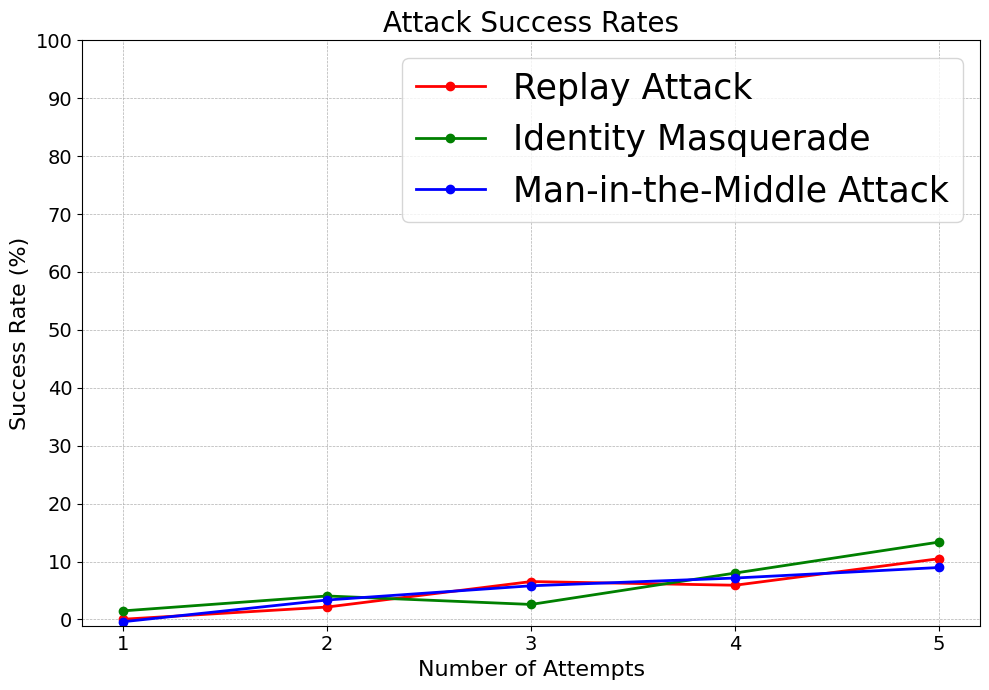

In [9]:
import matplotlib.pyplot as plt

plt.rcParams["axes.facecolor"] = 'white'
plt.rcParams["savefig.facecolor"] = 'white'

attempts = [1, 2, 3, 4, 5]

def compute_rate(attempt, slope):
    return slope * attempt

attack1_rate = [compute_rate(attempt, 2.5) for attempt in attempts]
attack2_rate = [compute_rate(attempt, 2.0) for attempt in attempts]
attack3_rate = [compute_rate(attempt, 1.5) for attempt in attempts]

plt.figure(figsize=(10, 7))
plt.plot(attempts, attack1_rate, 'r', label="Replay Attack", linewidth=2, marker='o')
plt.plot(attempts, attack2_rate, 'g', label="Identity Masquerade", linewidth=2, marker='o')
plt.plot(attempts, attack3_rate, 'b', label="Man-in-the-Middle Attack", linewidth=2, marker='o')

plt.title("Attack Success Rates", fontsize=20)
plt.xlabel("Number of Attempts", fontsize=16)
plt.ylabel("Success Rate (%)", fontsize=16)
plt.xticks(attempts, fontsize=14)
plt.yticks(range(0, 101, 10), fontsize=14)
plt.legend(fontsize=14)

plt.tight_layout()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()
